In [1]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Any, Tuple
import pickle
import torch
# from utilsHannes import mean_pointwise_l2_distance

def mean_pointwise_l2_distance(lattice: torch.Tensor, ground_truth: torch.Tensor) -> torch.Tensor:
    """
    Computes the index of the closest trajectory in the lattice as measured by l1 distance.
    :param lattice: Lattice of pre-generated trajectories. Shape [num_modes, n_timesteps, state_dim]
    :param ground_truth: Ground truth trajectory of agent. Shape [1, n_timesteps, state_dim].
    :return: Index of closest mode in the lattice.
    """
    stacked_ground_truth = ground_truth.repeat(lattice.shape[0], 1, 1)
    return torch.pow(lattice - stacked_ground_truth, 2).sum(dim=2).sqrt().mean(dim=1).argmin()


In [2]:
# Load lattice
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    trajectories8 = pickle.load(f)
lattice8 = np.array(trajectories8)
              
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_4.pkl', 'rb') as f:
    trajectories4 = pickle.load(f)
lattice4 = np.array(trajectories4)
    
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_2.pkl', 'rb') as f:
    trajectories2 = pickle.load(f)
lattice2 = np.array(trajectories2)

In [3]:
## Load data

# epochs = [50,51,52,53,54,55,56,57]
# legend_list = ['250*250','125*125','50*50','10*10','2*2','1*1','50*50 + covernet input','125*125 + covernet input']


# epochs = [499]
# legend_list = ['125*125 (569e)']
# num_epochs = 569


# With training results
# epochs = [500] #501
# legend_list = ['10*10 (570e), eps=8']#'250*250 (501e), eps=8'

# epochs = [502] # 502
# legend_list = ['250*250 (502e), eps=2']

# epochs = [503]
# legend_list = ['10*10 (167e), eps=2']

# epochs = [504]
# legend_list = ['10*10 (368e), eps=4']

# '50*50 (201e) + covernet modified, eps=4'
# '50*50 (202e), eps=4, lr=5e-5'

# # Epsilon coparison
# epochs = [500, 504, 503]
# legend_list = ['10*10 (570e), eps=8','10*10 (368e), eps=4', '10*10 (167e), eps=2']
# lattice_list = [lattice8, lattice4, lattice2]
# modes_list = [64, 415, 2206]
# dataset_factor_list = [1,1,1]
# num_epochs = 160

# # Dataset comparison
# epochs = [506, 505, 500]
# legend_list = ['10*10 (209e), eps=8, non-overlapping train', '10*10 (441e), eps=8, non-overlapping trainAndVal', '10*10 (570e), eps=8']
# dataset_factor_list = [1,2,1] # train [2,2,1]

# # Input size eps8 comparison
# epochs = [50,51,52,53,54,55]
# legend_list = ['250*250','125*125','50*50','10*10','2*2','1*1']
# dataset_factor_list = [1,1,1,1,1,1]

# Input size eps 8 LONG RUN
# epochs = [299,300,499,501,301]
# legend_list = ['10*10 (299e), eps=8','50*50 (300e), eps=8','125*125 (569e)','250*250 (501e), eps=8','500*500 (301e), eps=8']
# dataset_factor_list = [1,1,1,1,1]
# lattice_list = [lattice8, lattice8, lattice8, lattice8, lattice8]
# modes_list = [64, 64, 64, 64, 64]

# Input size eps4 comparison + kör även med modifierat covernet för extremfall + lr halverad
epochs = [504, 200, 203, 204, 205]
legend_list = ['10*10 (368e), eps=4', '50*50 (200e), eps=4', '125*125 (203e), eps=4', '250*250 (204e), eps=4', '500*500 (205e), eps=4']
dataset_factor_list = [1,1,1,1,1]
lattice_list = [lattice4, lattice4, lattice4, lattice4, lattice4]
modes_list = [415, 415, 415, 415, 415]
num_epochs = 200


# Files
file_path_list = [f"tmpResults/results_epochs={epoch}" for epoch in epochs]
num_files = len(file_path_list)

# Settings
file_number = 0
train_boolean = 'no' # yes

# Load the .npy files
if train_boolean == 'yes':
    logits_loaded_list = [(np.load(f'{file_path}_train_logits.npy'))[:num_epochs*2048*dataset_factor] for file_path, dataset_factor in zip(file_path_list, dataset_factor_list)]
    ground_truth_loaded_list = [(np.load(f'{file_path}_train_ground_truth.npy'))[:num_epochs*2048*dataset_factor] for file_path, dataset_factor in zip(file_path_list, dataset_factor_list)]
elif train_boolean == 'no':
    logits_loaded_list = [(np.load(f'{file_path}_val_logits.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_path_list, dataset_factor_list)]
    ground_truth_loaded_list = [(np.load(f'{file_path}_val_ground_truth.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_path_list, dataset_factor_list)]
else:
    logits_loaded_list = [(np.load(f'{file_path}_logits.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_path_list, dataset_factor_list)]
    ground_truth_loaded_list = [(np.load(f'{file_path}_ground_truth.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_path_list, dataset_factor_list)]
    
    

softmaxy = torch.nn.Softmax(dim=1)
probabilities_list = [softmaxy(torch.Tensor(logits)).detach().numpy().squeeze() for logits in logits_loaded_list]

############################# FLOWER ######################################

# # Settings
# file_number = 0
# train_boolean = 'no' # yes

# # Files
# file_name_list = ['iid_balanced_C=1_Cf=1.0_Ef=1.0_B=8_E=1_R=500_Opt=saveFedAvg_Lr=0.0001_eps=8','iid_balanced_C=1_Cf=1.0_Ef=1.0_B=8_E=1_R=500_Opt=saveFedAvg_Lr=0.0001','iid_balanced_C=2_Cf=1.0_Ef=1.0_B=8_E=1_R=200_Opt=saveFedAvg_Lr=0.0001_eps=8', 'iid_balanced_C=2_Cf=1.0_Ef=1.0_B=8_E=1_R=200_Opt=saveFedAvg_Lr=0.0001']  
# num_files = len(file_name_list)
# legend_list = ['C=1, eps8, R500', 'C=1, eps4, R500',' C=2, eps8, R200', ' C=2, eps4, R200']
# dataset_factor_list = [1,1,1,1]
# lattice_list = [lattice8, lattice4, lattice8, lattice4]
# modes_list = [64, 415, 64, 415]

# num_epochs = 200

# ## Load from flower:
# logits_loaded_list = [(np.load(f'tmpResults_copy2/val_logits_{file_name}.npy'))[:num_epochs*512*dataset_factor] for file_name, dataset_factor in zip(file_name_list, dataset_factor_list)]
# ground_truth_loaded_list = [(np.load(f'tmpResults_copy2/val_ground_truth_{file_name}.npy'))[:num_epochs*512*dataset_factor] for file_name, dataset_factor in zip(file_name_list, dataset_factor_list)]

# softmaxy = torch.nn.Softmax(dim=1)
# probabilities_list = [softmaxy(torch.Tensor(logits)).detach().numpy().squeeze() for logits in logits_loaded_list]

#################################################################################################################################

# ############################# Modified logits CL ######################################

# # Save top15 comparison
# epochs = [298]
# legend_list = ['10*10 (298e) eps=4 top15', '10*10 (299e) eps=8 top64']
# dataset_factor_list = [1,1]
# lattice_list = [lattice4, lattice8]
# modes_list = [15, 64]
# num_epochs = 230

# # Files
# file_path_list = [f"tmpResults/results_epochs={epoch}" for epoch in epochs]
# num_files = len(file_path_list)

# # Settings
# file_number = 0
# train_boolean = 'no' # yes


# indices_loaded_list = [(np.load(f'{file_path}_val_indices.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_path_list, dataset_factor_list)]
# probabilities_list = [(np.load(f'{file_path}_val_probabilities.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_path_list, dataset_factor_list)]
# ground_truth_loaded_list = [(np.load(f'{file_path}_val_ground_truth.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_path_list, dataset_factor_list)]

# #################################################################################################################################



# # Print the data
# print(f"len(indices_loaded_list) = {len(indices_loaded_list)}")
# print(f"len(probabilities_list) = {len(probabilities_list)}")
# print(f"len(ground_truth_loaded_list) = {len(ground_truth_loaded_list)}")
# print(f"indices_loaded_list[{file_number}].shape = {indices_loaded_list[file_number].shape}")
# print(f"probabilities_list[{file_number}].shape = {probabilities_list[file_number].shape}")
# print(f"ground_truth_loaded_list[{file_number}].shape = {ground_truth_loaded_list[file_number].shape}")



In [4]:
# ## Functions new

# def get_sorted_most_likely_trajectories(sortedProbabilitiesIndices: np.ndarray, lattice: np.ndarray): # -> Tuple[np.ndarray, np.ndarray]:
    
#     sortedTrajectories = lattice[sortedProbabilitiesIndices]
    
#     return sortedTrajectories


# def get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_trajectories, k_nr_of_trajectories, train_boolean, dataset_factor): # -> Tuple[np.array, np.array]:
    
#     top_k_trajectories = sorted_predicted_trajectories[:,:k_nr_of_trajectories,:,:]
    
#     n_epochs = num_epochs # TODO, automate
#     if train_boolean == 'yes':
#         n_datapoints_per_epoch = 2048*dataset_factor # TODO, automate
#     else:
#         n_datapoints_per_epoch = 512*dataset_factor # TODO, automate
    
#     ave_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
#     min_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
#     count = 0
#     # Loop over epochs
#     for e in range(n_epochs):
        
#         # Loop over datapoints
#         for d in range(n_datapoints_per_epoch):
#             tmp_ADE = 1e10
#             min_ADE[d,e] = tmp_ADE
#             # Loop over each trajectory
#             for k in range(k_nr_of_trajectories):
#                 tmp_ADE = np.mean(np.linalg.norm(top_k_trajectories[count,k,:,:] - ground_truth_trajectories[count,:,:], axis=-1))
#                 ave_ADE[d,e] += tmp_ADE/k_nr_of_trajectories
#                 if tmp_ADE < min_ADE[d,e]:
#                     min_ADE[d,e] = tmp_ADE
#             count += 1
            
#     return np.mean(min_ADE, axis=0), np.mean(ave_ADE, axis=0)




## Functions OLD logits

def get_sorted_most_likely_trajectories(logits: np.ndarray, lattice: np.ndarray): # -> Tuple[np.ndarray, np.ndarray]:
    
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(torch.Tensor(logits))
    sortedProbabilitiesIndices = np.flip(np.array(np.argsort(probabilities, axis=-1)), axis=-1).copy()
    sortedProbabilities = np.array(np.take_along_axis(probabilities, sortedProbabilitiesIndices, axis=-1))
    sortedTrajectories = lattice[sortedProbabilitiesIndices]
    
    return sortedProbabilities, sortedTrajectories


def get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_trajectories, k_nr_of_trajectories, train_boolean, dataset_factor): # -> Tuple[np.array, np.array]:
    
    top_k_trajectories = sorted_predicted_trajectories[:,:k_nr_of_trajectories,:,:]
    
    n_epochs = num_epochs # TODO, automate
    if train_boolean == 'yes':
        n_datapoints_per_epoch = 2048*dataset_factor # TODO, automate
    else:
        n_datapoints_per_epoch = 512*dataset_factor # TODO, automate
    
    ave_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    min_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    count = 0
    # Loop over epochs
    for e in range(n_epochs):
        
        # Loop over datapoints
        for d in range(n_datapoints_per_epoch):
            tmp_ADE = 1e10
            min_ADE[d,e] = tmp_ADE
            # Loop over each trajectory
            for k in range(k_nr_of_trajectories):
                tmp_ADE = np.mean(np.linalg.norm(top_k_trajectories[count,k,:,:] - ground_truth_trajectories[count,:,:], axis=-1))
                ave_ADE[d,e] += tmp_ADE/k_nr_of_trajectories
                if tmp_ADE < min_ADE[d,e]:
                    min_ADE[d,e] = tmp_ADE
            count += 1
            
    return np.mean(min_ADE, axis=0), np.mean(ave_ADE, axis=0)


In [5]:
############### Calculate and plot many files

k_nr_of_trajectories = 5

# OLD logits
results1 = [get_sorted_most_likely_trajectories(logits_loaded, lattice) for logits_loaded, lattice in zip(logits_loaded_list, lattice_list)]
sorted_predicted_probabilities_list, sorted_predicted_trajectories_list = zip(*results1)

# # New
# sorted_predicted_trajectories_list = [get_sorted_most_likely_trajectories(indices_loaded, lattice) for indices_loaded, lattice in zip(indices_loaded_list, lattice_list)]
# sorted_predicted_probabilities_list = probabilities_list.copy()

results2 = [get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_loaded, k_nr_of_trajectories, train_boolean, dataset_factor) for sorted_predicted_trajectories, ground_truth_loaded, dataset_factor in zip(sorted_predicted_trajectories_list, ground_truth_loaded_list, dataset_factor_list)]
min_ADE_list, ave_ADE_list = zip(*results2)

print(f"len(sorted_predicted_probabilities_list) = {len(sorted_predicted_probabilities_list)}")
print(f"len(sorted_predicted_trajectories_list) = {len(sorted_predicted_trajectories_list)}")
print(f"sorted_predicted_probabilities_list[{file_number}].shape = {sorted_predicted_probabilities_list[file_number].shape}")
print(f"sorted_predicted_trajectories_list[{file_number}].shape = {sorted_predicted_trajectories_list[file_number].shape}")
# print(f"sortedTrajectories = {sorted_predicted_trajectories_list[0][2]}") # [0][0/1] and [0][2/3] the same

print(f"\nmin_ADE_list[{file_number}].shape = {min_ADE_list[file_number].shape}")
print(f"\nave_ADE_list[{file_number}].shape = {ave_ADE_list[file_number].shape}")
print(f"\nmin_ADE_list[{file_number}][-1] = {min_ADE_list[file_number][-1]}")
print(f"\nave_ADE_list[{file_number}][-1] = {ave_ADE_list[file_number][-1]}")


len(sorted_predicted_probabilities_list) = 5
len(sorted_predicted_trajectories_list) = 5
sorted_predicted_probabilities_list[0].shape = (102400, 415)
sorted_predicted_trajectories_list[0].shape = (102400, 415, 12, 2)

min_ADE_list[0].shape = (200,)

ave_ADE_list[0].shape = (200,)

min_ADE_list[0][-1] = 2.6165183143747397

ave_ADE_list[0][-1] = 6.420184915724375


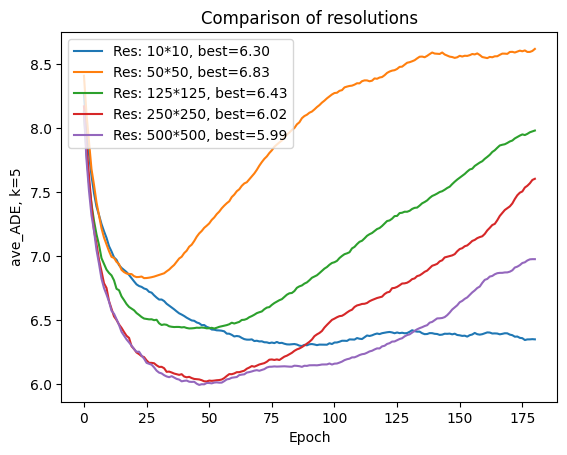

In [21]:
start_number = 0
window_size = 20
smooth_min_ADE_list = [np.convolve(min_ADE[start_number:], np.ones(window_size)/window_size, mode='valid') for min_ADE in min_ADE_list]
smooth_ave_ADE_list = [np.convolve(ave_ADE[start_number:], np.ones(window_size)/window_size, mode='valid') for ave_ADE in ave_ADE_list]
best_smooth_min_ADE_list = [min(smooth_min_ADE) for smooth_min_ADE in smooth_min_ADE_list]
best_smooth_ave_ADE_list = [min(smooth_ave_ADE) for smooth_ave_ADE in smooth_ave_ADE_list]
## Plot ADE
legend_list = ['Res: 10*10', 'Res: 50*50', 'Res: 125*125', 'Res: 250*250', 'Res: 500*500']
# [plt.plot(min_ADE, label=legend+f', best={best_min_ADE:.2f}') for min_ADE, legend, best_min_ADE in zip(smooth_min_ADE_list, legend_list, best_smooth_min_ADE_list)]
[plt.plot(ave_ADE, label=legend+f', best={best_ave_ADE:.2f}') for ave_ADE, legend, best_ave_ADE in zip(smooth_ave_ADE_list, legend_list, best_smooth_ave_ADE_list)]


plt.legend();
plt.xlabel('Epoch')
plt.ylabel('ave_ADE, k=5')
plt.title(f"Comparison of resolutions");
plt.savefig("saveResults/compareDatasets/compareResolutions.png")

sorted_predicted_probabilities.shape = (102400, 415)
sorted_predicted_trajectories.shape = (102400, 415, 12, 2)

min_ADE.shape = (200,)

ave_ADE.shape = (200,)

min_ADE[-1] = 5.788536242172015

ave_ADE[-1] = 5.788536242172015


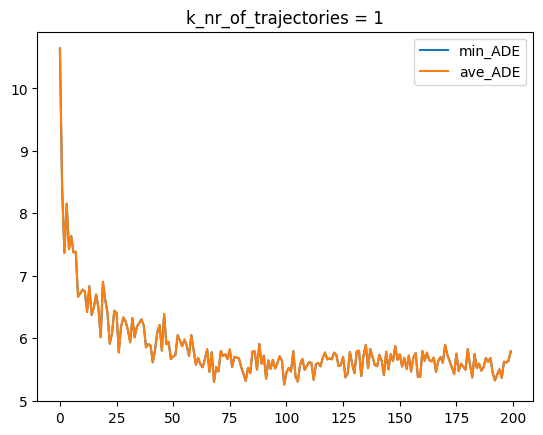

In [7]:
# OLD logits
############## Calculate and plot one file

k_nr_of_trajectories = 1

sorted_predicted_probabilities, sorted_predicted_trajectories = get_sorted_most_likely_trajectories(logits_loaded_list[file_number], lattice_list[file_number])
min_ADE, ave_ADE = get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_loaded_list[file_number], k_nr_of_trajectories, train_boolean, dataset_factor_list[file_number])

print(f"sorted_predicted_probabilities.shape = {sorted_predicted_probabilities.shape}")
print(f"sorted_predicted_trajectories.shape = {sorted_predicted_trajectories.shape}")
print(f"\nmin_ADE.shape = {min_ADE.shape}")
print(f"\nave_ADE.shape = {ave_ADE.shape}")
print(f"\nmin_ADE[-1] = {min_ADE[-1]}")
print(f"\nave_ADE[-1] = {ave_ADE[-1]}")

### One file ###
plt.plot(min_ADE, label="min_ADE")
plt.plot(ave_ADE, label="ave_ADE")
plt.legend();
plt.title(f"k_nr_of_trajectories = {k_nr_of_trajectories}");


predicted = 22
closest_lattice_index = 22
correct = True


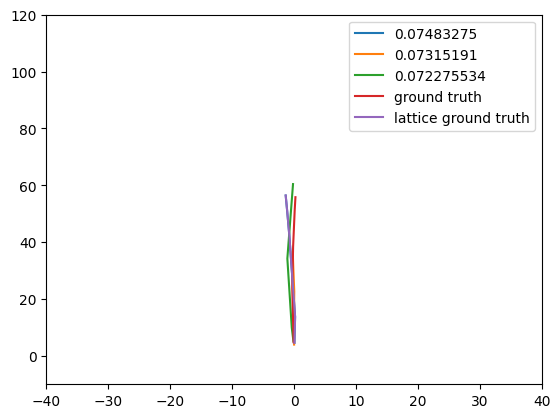

In [8]:
## Plot prediction vs ground truth
epoch = 150
index = 22
if train_boolean == 'yes':
    test_index = epoch*2048*dataset_factor_list[file_number] + index
else: 
    test_index = epoch*512*dataset_factor_list[file_number] + index
    
nrOfTopTrajectories = 3
ground_truth_trajectory = ground_truth_loaded_list[file_number][test_index]
probabilities = probabilities_list[file_number][test_index]
closest_lattice_index = mean_pointwise_l2_distance(torch.Tensor(lattice_list[file_number]), torch.Tensor(ground_truth_trajectory))
topProbabilitiesIndices = np.argsort(probabilities)[::-1][0:nrOfTopTrajectories]
topProbabilities = [probabilities[index] for index in topProbabilitiesIndices]

# Lattice ground truth
predicted = topProbabilitiesIndices[0]
print(f"predicted = {predicted}")
print(f"closest_lattice_index = {closest_lattice_index}")
correct = (predicted == closest_lattice_index)
print(f"correct = {correct}")

# Plot predictions
[plt.plot(lattice_list[file_number][mode,:,0],lattice_list[file_number][mode,:,1], label=topProbabilities[i]) for i, mode in enumerate(topProbabilitiesIndices)]
# Plot ground truth
plt.plot(ground_truth_trajectory[:,0], ground_truth_trajectory[:,1], label="ground truth")
# Plot lattice ground truth
plt.plot(lattice_list[file_number][closest_lattice_index,:,0],lattice_list[file_number][closest_lattice_index,:,1], label="lattice ground truth")
plt.ylim([-10,120]); plt.xlim([-40,40]); plt.legend(); plt.show()

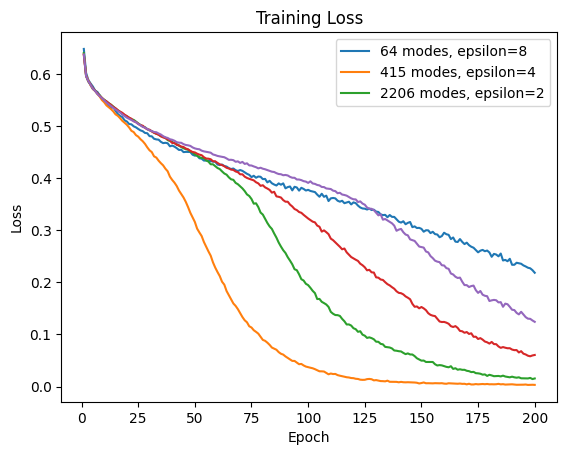

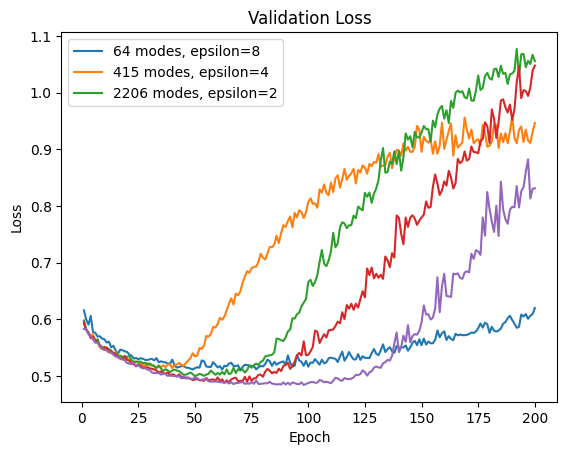

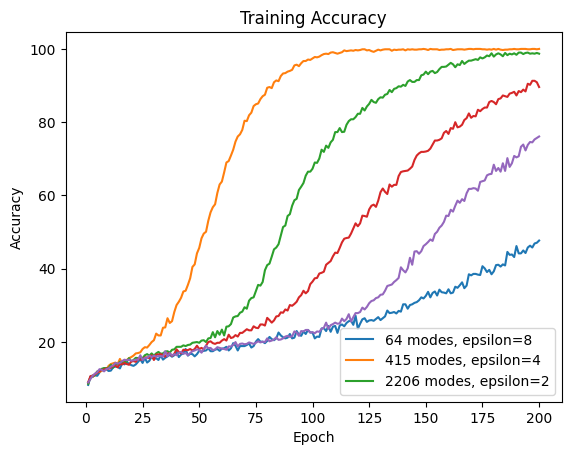

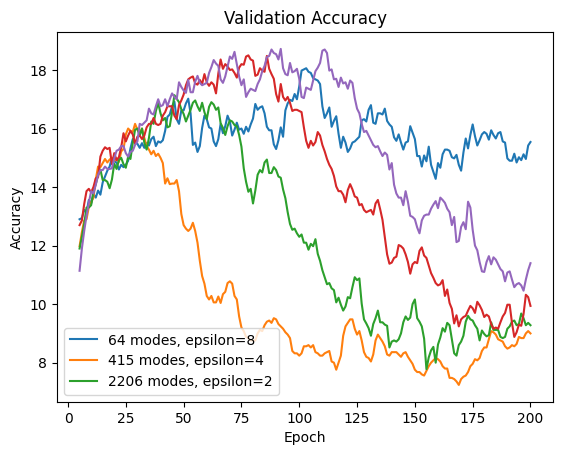

In [9]:
## Plot loss and accuracy

# File names
loss_acc_file_names = [f"{file_path}_loss_and_acc.txt" for file_path in file_path_list]

# Create empty arrays to store the data from text files
epochs = np.zeros((num_files, num_epochs))
train_loss = np.zeros((num_files, num_epochs))
val_loss = np.zeros((num_files, num_epochs))
train_acc = np.zeros((num_files, num_epochs))
val_acc = np.zeros((num_files, num_epochs))

# Loop over the text files
for i, filename in enumerate(loss_acc_file_names):
    with open(filename, 'r') as f:
        for j, line in enumerate(f):
            if j == num_epochs:
                break
            if line.startswith('Epoch'):
                parts = line.split(': ')
                epoch = int(parts[0].split('[')[1].split('/')[0])
                epochs[i][j] = epoch
                train_loss[i][j] = float(parts[2].split(' |')[0])
                val_loss[i][j] = float(parts[3].split(' |')[0])
                train_acc[i][j] = float(parts[4].split(' %')[0])
                val_acc[i][j] = float(parts[5].split(' %')[0])
if num_files > 4:
    val_loss[4,0] = val_loss[4,1]



# Training loss
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], train_loss[i], label=f'File {i+1}')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(legend_list)
plt.show()

# Validation loss
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], val_loss[i], label=f'File {i+1}')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(legend_list)
plt.show()

# Training accuracy
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], train_acc[i], label=f'File {i+1}')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(legend_list)
plt.show()

# Validation accuracy
plt.figure()
for i in range(num_files):
    # Convert the list to a pandas DataFrame
    df = pd.DataFrame(val_acc[i])
    # Apply a rolling window of size x and take the mean of each window
    smoothed = df.rolling(5).mean()
    # Convert the smoothed DataFrame back to a list
    smoothed_list = smoothed.values.tolist()
    numpy_smoothed_list = np.array(smoothed_list)
    squeezed_numpy_smoothed_list = np.squeeze(numpy_smoothed_list, 1)
    plt.plot(epochs[i], squeezed_numpy_smoothed_list, label=f'File {i+1}')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(legend_list)
plt.show()


(array([ 9., 19., 14., 14., 20.,  9., 13., 14.,  9., 15.,  7.,  3.,  6.,
         4., 54.,  5.,  1., 10.,  4.,  5., 10.,  2., 15.,  4.,  1.,  1.,
         1.,  3.,  8.,  1.,  0.,  0.,  1.,  2.,  2.,  1.,  1.,  1.,  2.,
         0.,  0.,  2.,  2.,  1.,  3.,  0.,  3.,  3.,  1.,  0.,  3.,  0.,
         1.,  9.,  1.,  0.,  1.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  1.,  6.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  3.,
         1.,  0.,  4.,  0.,  0.,  1.,  1.,  1.,  3.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  3.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  6.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  3.,
         0.,  2.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  4.,  1.,  0.,  0.,  0.,  0.

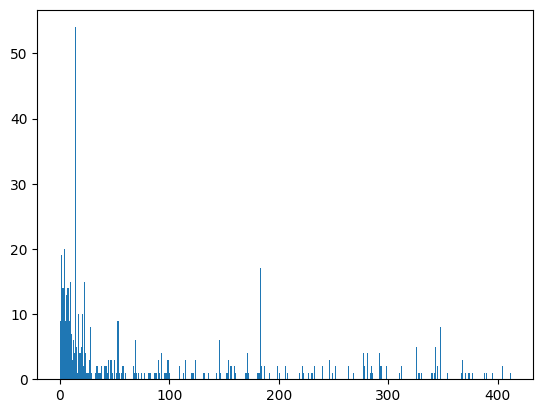

In [10]:
# Histogram of grount truth trajectories

if train_boolean == 'yes':
    nr_datapoints = 2048*dataset_factor_list[file_number]
else: 
    nr_datapoints = 512*dataset_factor_list[file_number]
    
closest_lattice_index = [mean_pointwise_l2_distance(torch.Tensor(lattice_list[file_number]), torch.Tensor(ground_truth_trajectory)) for ground_truth_trajectory in ground_truth_loaded_list[file_number][:nr_datapoints]]

plt.hist(closest_lattice_index, bins = modes_list[file_number])
